# Principal Component Analysis (PCA)

Given a set of $n$ data points in $d$ dimensions, can we reduce the dimensionality of the data while not distorting the data too much? Perhaps a good way to do this is to project the data onto a $k$-dimensional linear subspace of $\mathbb{R}^d$. PCA gives us a new orthonormal basis $\boldsymbol{v_1}, \ldots, \boldsymbol{v_d}$ such that $span\{\boldsymbol{v_1}, \ldots, \boldsymbol{v_k}\}$ is a "best-fit" linear subspace for all $1 \leq k \leq d$. We also get numbers $\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_d \geq 0$ which tell us how much information is contained in the corresponding basis vector. We can then use this to find the "best" $k$-dimensional linear subspace and pick a reasonable $k$. We will go through the mathematical derivation and an implementation in Python.

## Set-up

Suppose we have $n$ mean-centered $d$-dimensional data points $\boldsymbol{x_1}, \ldots, \boldsymbol{x_n} \in \mathbb{R}^d$ represented in the rows of a $n \times d$ data matrix $X$ and we want to reduce the dimensionality of $X$. Let's try to find the best $k$-dimensional linear subspace of $\mathbb{R}^d$ to project the data onto. 

First, we need to think of what it means to be the "best" subspace. An obvious and good choice is the sum of squared lengths of the projection of each data point onto the subspace. This can be thought of as the error introduced by projecting that point, i.e. the squared distance between the original point and the projected point. 

Initially we will show how to find that best subspace for when $k=1$. Let $\boldsymbol{v} \in \mathbb{R}^d$ be an arbitrary vector. We define the vector projection of $\boldsymbol{x}$ onto $\boldsymbol{v}$ by $proj_\boldsymbol{v}(\boldsymbol{x}) = \frac{\boldsymbol{x} \cdot \boldsymbol{v}}{\boldsymbol{v} \cdot \boldsymbol{v}}\boldsymbol{v}$ and the error of projecting $\boldsymbol{x_i}$ onto $\boldsymbol{v}$ as $error_\boldsymbol{v}(\boldsymbol{x_i}) = \boldsymbol{x_i} - proj_\boldsymbol{v}(\boldsymbol{x_i})$ (this is also known as the vector rejection of $\boldsymbol{x_i}$ on $\boldsymbol{v}$). So
    $$\|x_i\|^2 = \|proj_{\boldsymbol{v}}(x_i)\|^2 + \|error_\boldsymbol{v}(x_i)\|^2$$
where $\|\cdot\|$ represents the Euclidean distance. Note that $\|x_i\|^2$ is fixed, but we can change the terms on the right side by changing the vector $\boldsymbol{v}$. If $\boldsymbol{v}$ is closer $\boldsymbol{x_i}$, then $\|proj_{\boldsymbol{v}}(x_i)\|^2$ gets bigger and $\|error_\boldsymbol{v}(x_i)\|^2$ gets smaller. Our goal then is to find $\operatorname*{argmin}_{\boldsymbol{v} \in \mathbb{R}^d}\sum_{i=1}^n \|error_\boldsymbol{v}(\boldsymbol{x_i})\|^2$. 

Since we are looking for an orthonormal basis, without loss of generality we will restrict our vector search to unit vectors. Let $S^{d-1} = \{\boldsymbol{u} \in \mathbb{R}^d : \|\boldsymbol{u}\| = 1 \}$ be the unit (d-1)-sphere, the set of all $d$-dimensional unit vectors (see https://en.wikipedia.org/wiki/N-sphere for why this notation makes sense).

Note that minimizing $\sum_{i=1}^n \|error_\boldsymbol{u}(\boldsymbol{x_i})\|^2$  is the same as maximizing $\sum_{i=1}^n \|proj_\boldsymbol{u}(\boldsymbol{x_i})\|^2$. We now redefine our goal to be 
$$\operatorname*{argmax}_{\boldsymbol{u} \in S^{d-1}}\sum_{i=1}^n \|proj_\boldsymbol{u}(\boldsymbol{x_i})\|^2$$
Essentially, we want to find the direction that captures the most variance in the data.

Then for all $\boldsymbol{u} \in S^{d-1}$
\begin{align*}
    \sum_{i=1}^n\|proj_\boldsymbol{u}(\boldsymbol{x_i})\|^2
                        &= \sum_{i=1}^n (\boldsymbol{x_i} \cdot \boldsymbol{u})^2\|\boldsymbol{u}\|^2\\
                        &= \sum_{i=1}^n (\boldsymbol{x_i} \cdot \boldsymbol{u})^2\\
                        &= ||X\boldsymbol{u}||^2\\
                        &= X\boldsymbol{u} \cdot X\boldsymbol{u}\\
                        &= (X\boldsymbol{u})^T \cdot X\boldsymbol{u}\\
                        &= \boldsymbol{u}^T (X^TX)\boldsymbol{u}\\
                        &= \boldsymbol{u}^T\Sigma_X\boldsymbol{u}
\end{align*}
where $\Sigma_X = X^TX$ is the $d \times d$ covariance matrix of $X$.

We can now redefine our goal to be finding
$\operatorname*{argmax}_{\boldsymbol{u} \in S^{d-1}}\boldsymbol{u}^T\Sigma_X\boldsymbol{u}$.

## Some useful facts about $\Sigma_X$

1. $\Sigma_X$ contains only real-valued entries
2. $\Sigma_X$ is symmetric  
 **Proof**: $\Sigma_X^T = (X^TX)^T = X^TX = \Sigma_X$ $\square$
3. $\Sigma_X$ is positive semidefinite, i.e. $\boldsymbol{v}^T\Sigma_X\boldsymbol{v} \geq 0$ for all $\boldsymbol{v} \in \mathbb{R}^d$.  
 
 **Proof**: Let $\boldsymbol{v}$ be an arbitrary vector in $\mathbb{R}^d$. Then
\begin{align*}
             \boldsymbol{v}^T\Sigma_X\boldsymbol{v} &= \boldsymbol{v}^TX^TX\boldsymbol{v}\\
                                                    &= (X\boldsymbol{v})^TX\boldsymbol{v}\\
                                                    &= \|X\boldsymbol{v}\|^2\\
                                                    &\geq 0
\end{align*}
$\square$

From facts 1 and 2 we can conclude that all eigenvalues of $\Sigma_X$ are real and that $\Sigma_X$ is orthogonally diagonalizable, i.e. we can find a set of vectors $\boldsymbol{v_1}, \ldots, \boldsymbol{v_d}$ which is orthonormal, forms a basis for $\mathbb{R}^d$, and are the eigenvectors of $\Sigma_X$ (proofs omitted). From fact 3 we can conclude that all eigenvalues of $\Sigma_X$ are non-negative.

**Proof**: Suppose $\Sigma_X$ is positive semidefinite and $\lambda$ is an eigenvalue of $\Sigma_X$. Therefore there exists $\boldsymbol{v} \in \mathbb{R}^d$ such that $\Sigma_X\boldsymbol{v} = \lambda\boldsymbol{v}, \boldsymbol{v} \neq 0$. Left multiplying on both sides by $\boldsymbol{v}^T$ give us
    $$\boldsymbol{v}^T\Sigma_X\boldsymbol{v} = \lambda\boldsymbol{v}^T\boldsymbol{v} = \lambda\|\boldsymbol{v}\|^2 \geq 0$$
Since $\boldsymbol{v}^T\Sigma_X\boldsymbol{v} \geq 0$, we have $\lambda\|\boldsymbol{v}\|^2 \geq 0$. By definition $\|\boldsymbol{v}\|^2$ is non-negative, $\lambda$ must also be non-negative. $\square$

So we know $\Sigma_X$ has $d$ real, positive eigenvalues which we will denote for the rest of this post by $\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_d \geq 0$ with associated eigenvectors $\boldsymbol{v_1}, \ldots, \boldsymbol{v_d}$ which form an orthonormal basis for $\mathbb{R}^d$. Also, since $\Sigma_X$ is orthogonally diagonalizable, we can rewrite it as $\Sigma_X = V\Lambda V^T$ where $\boldsymbol{v_i}$ is the $i^{th}$ column of $V$ and $\Lambda$ is a diagonal matrix with $\Lambda_{ii} = \lambda_i$.

## Finding the optimal vectors

First we show that $\operatorname*{argmax}_{\boldsymbol{u} \in S^{d-1}}\boldsymbol{u}^T\Sigma_X\boldsymbol{u} = \boldsymbol{v_1}$
where $\boldsymbol{v_1}$ is the eigenvector corresponding to the largest eigenvalue $\lambda_1$, which is the maximum value $\boldsymbol{u}^T\Sigma_X\boldsymbol{u}$ can take on.


**Proof**: Fix a unit vector $\boldsymbol{u} \in S^{d-1}$. Note that since the eigenvectors of $\Sigma_X$ form an orthonormal basis for $\mathbb{R}^d$, there exist unique scalars $c_1, \ldots, c_d \in \mathbb{R}$ such that $\boldsymbol{u} = c_1\boldsymbol{v_1} + \ldots + c_d\boldsymbol{v_d}$. Define the function $F(\boldsymbol{u}) = \boldsymbol{u}^T\Sigma_X\boldsymbol{u}$.

\begin{align*}
    F(\boldsymbol{u}) &= \boldsymbol{u}^T\Sigma_X\boldsymbol{u}\\ &= (c_1\boldsymbol{v_1}^T + \ldots + c_d\boldsymbol{v_d}^T)\Sigma_X(c_1\boldsymbol{v_1} + \ldots + c_d\boldsymbol{v_d})\\
                                           &= (c_1\boldsymbol{v_1}^T + \ldots + c_d\boldsymbol{v_d}^T)(c_1\lambda_1\boldsymbol{v_1} + \ldots + c_d\lambda_d\boldsymbol{v_d})\\
\end{align*}

Thankfully most of these terms will simplify, $\boldsymbol{v_i}^T\boldsymbol{v_j} = 0$ when $i \neq j$ since the set of eigenvectors is orthogonal and $\boldsymbol{v_i}^T\boldsymbol{v_i} = \|\boldsymbol{v_i}\|^2 = 1$ since the eigenvectors are normal. Working that out results in

$$(c_1\boldsymbol{v_1}^T + \ldots + c_d\boldsymbol{v_d}^T)(c_1\lambda_1\boldsymbol{v_1} + \ldots + c_d\lambda_d\boldsymbol{v_d}) = \lambda_1c_1^2 + \ldots + \lambda_dc_d^2$$

Since $\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_d \geq 0$ we have

$$\lambda_1c_1^2 + \ldots + \lambda_dc_d^2 \leq \lambda_1(c_1^2 + \ldots + c_d^2) = \lambda_1$$

So for any unit vector $\boldsymbol{u}$, $\lambda_1$ is an upper bound. However, note that $F(\boldsymbol{v_1}) = \lambda_1$, since in the above line we'd have $c_1 = 1$ and all other $c_i = 0$. Therefore the maximum value $F$ can take is $\lambda_1$ which it attains at $\boldsymbol{v_1}$. $\square$

If we want to reduce our data to 1 dimension, projecting it onto $span\{\boldsymbol{v_1}\}$ will maintain the most information out of all possible vectors we could project onto. In other words $span\{\boldsymbol{v_1}\}$ is the best-fit 1-dimensional subspace for the data.

Now let's extend this to the general $k$ dimensional case. If $\boldsymbol{v_1}$ is the direction that has the maximum variance, then the next vector should be the one with the maximum variance that is orthogonal to $\boldsymbol{v_1}$.
Thankfully, we can use a similar proof from the 1-dimensional case to show that 
$$\operatorname*{argmax}_{\substack{\boldsymbol{u} \in S^{d-1} \\ \boldsymbol{u} \bot \boldsymbol{v_1}}}\boldsymbol{u}^T\Sigma_X\boldsymbol{u} = \boldsymbol{v_2}$$
and more generally, for $i = 2, 3, \ldots, k$,
$$\operatorname*{argmax}_{\substack{\boldsymbol{u} \in S^{d-1} \\ \boldsymbol{u} \bot \boldsymbol{v_1}, \ldots, \boldsymbol{v_{i-1}}}}\boldsymbol{u}^T\Sigma_X\boldsymbol{u} = \boldsymbol{v_i}$$
and
$$\max_{\substack{\boldsymbol{u} \in S^{d-1} \\ \boldsymbol{u} \bot \boldsymbol{v_1}, \ldots, \boldsymbol{v_{i-1}}}}\boldsymbol{u}^T\Sigma_X\boldsymbol{u} = \lambda_i$$

**Proof**: Let the set-up be the same as above, but where $F(\boldsymbol{u}) = \operatorname*{argmax}_{\substack{\boldsymbol{u} \in S^{d-1} \\ \boldsymbol{u} \bot \boldsymbol{v_1}, \ldots, \boldsymbol{v_{i-1}}}}\boldsymbol{u}^T\Sigma_X\boldsymbol{u}$. We still have $F(\boldsymbol{u}) = \lambda_1c_1^2 + \ldots + \lambda_dc_d^2$. Due to the orthogonality constraint, $c_1 = \ldots = c_{i-1} = 0$. Using a similar argument as the previous proof, the constrained maximum of $F(\boldsymbol{u})$ is $\lambda_i$ which is attained at $\boldsymbol{v_i}$. $\square$

Therefore, the new orthonormal basis is formed by the eigenvectors $\{\boldsymbol{v_1}, \ldots \boldsymbol{v_d}\}$. We also know that for any $k$, $span\{\boldsymbol{v_1}, \ldots, \boldsymbol{v_k}\}$ is the best-fit $k$-dimensional subspace for the data. So if we want to reduce the data to $k$ dimensions, the subspace spanned by $\boldsymbol{v_1}, \ldots, \boldsymbol{v_k}$ is the best subspace to project onto. 

We typically call $\boldsymbol{v_i}$ the $i^{th}$ principal component (PC) and $\lambda_i$ the $i^{th}$ principal component score (PC score) of the data $X$.  

## Determining the amount of variation preserved

Now let's look at how much variation is preserved by a dimension reduction to $k$ dimensions.

First, we'll need to determine the total variance in the initial data. Recall that the covariance matrix holds the variance for $\boldsymbol{x_i}$ in $(\Sigma_X)_{ii}$, therefore the total variance in the data is $\sum_{i=1}^d (\Sigma_X)_{ii} = \operatorname{tr}(\Sigma_X)$. Also recall that $\Sigma_X$ is orthogonally diagonalizable, so we can write it as $\Sigma_X = V\Lambda V^T$. Therefore $\operatorname{Var}(X) = \operatorname{tr}(\Sigma_X) = \operatorname{tr}(V\Lambda V^T) = \operatorname{tr}(\Lambda) = \lambda_1 + \ldots + \lambda_d$. The total variance in the data is simply the sum of the PC scores. 

Perhaps unsurprisingly, the variance explained by the $j^{th}$ principal component $\boldsymbol{v_j}$ is $\lambda_j$. 

**Proof**:
\begin{align*}
    \sum_{i=1}^n \|proj_{\boldsymbol{v_j}}(\boldsymbol{x_i})\|^2 &= \sum_{i=1}^n (\boldsymbol{x_i} \cdot \boldsymbol{v_j})^2\\
                &= \|X\boldsymbol{v_j}\|^2\\
                &= \boldsymbol{v_j}^TX^TX\boldsymbol{v_j}\\
                &= \boldsymbol{v_j}^T\Sigma_X\boldsymbol{v_j}\\
                &= \lambda_j
\end{align*}
$\square$

Therefore the percent of variation explained by the $j^{th}$ principal component $\boldsymbol{v_j}$ is $\dfrac{\lambda_j}{\lambda_1 + \ldots + \lambda_d}$. Typically we will be projecting onto the first $k$ principal components, so for any $1 \leq k \leq d, \sum_{i=1}^n \|proj_{span\{\boldsymbol{v_1}, \ldots, \boldsymbol{v_k}\}}(\boldsymbol{x_i})\|^2 = \dfrac{\lambda_1 + \ldots + \lambda_j}{\lambda_1 + \ldots + \lambda_d}$ is the percent of variation explained by the first $k$ principal components.

Now, we can easily calculate the percentage of variation explained with any choice of $k$. This gives us a way to compare different values of $k$. Clearly, you want to preserve as much of the variation as possible. However, the percentage of variation preserved is a non-decreasing function with respect to $k$. So the lower the dimension you reduce to, the less variation you preserve. 

Selecting a $k$ is more of an art than a science, and depends on why you want to reduce the dimensionality of your data in the first place. A common tool used to help determine $k$ is a plot with component number on the x-axis and the respective eigenvalues on the y-axis. This is called a scree plot. Often you will have a relatively sharp drop-off followed by a flattening out. Selecting the component where the plot begins flattening out is a good general rule of thumb, because once it's flattened out the additional dimensions aren't adding much additional information.

It's also good keep percentage of variation explained in mind if you're using PCA to reduce to 2 or 3 dimensions for visualization purposes. If it turns out your reduction to 3-dimensions only explains a relatively small portion of the original variation, you're probably not looking at a very accurate representation of the data.

## A computational consideration

We could certainly put together an implementation of PCA from everything above. Center the data, calculate the covariance matrix, find the eigenvalues and eigenvectors, then project the data onto the span of the first $k$ eigenvectors. However, calculating the covariance matrix, and then finding the eigenvalues and eigenvectors with an eigendecomposition tends to be numerically unstable and slower than other methods. The typical method used is the singular value decomposition (SVD) of $X$. I won't go into detail about the SVD here, but essentially it is a matrix factorization method that allows us to write $X = UDV^T$, where the columns of $U$ and $V$ are orthonormal and $D$ is a diagonal matrix with real, positive entries. It is straightforward to see the equivalence between the SVD of $X$ and the eigendecomposition of $X^TX$

\begin{align*}
    X^TX &= (UDV^T)^T(UDV^T)\\
         &= VD(U^TU)DV^T\\
         &= VD^2V^T
\end{align*}

Note since $U$ is orthonormal, $U^T = U^{-1}$ and thus $U^TU = I$. This result looks very similar to the eigendecomposition of $X^TX$. It turns out the $V$ matrix is the same, the columns are the eigenvectors of $X^TX$ and form an orthonormal set. The $D$ matrix, whose entries are called the singular values, are just the square roots of the eigenvalues of $X^TX$, i.e. $D_{ii}^2 = \lambda_i$. So calculating the SVD of $X$ gives us all the information we need to do PCA in a faster and more accurate way.

## Implementation

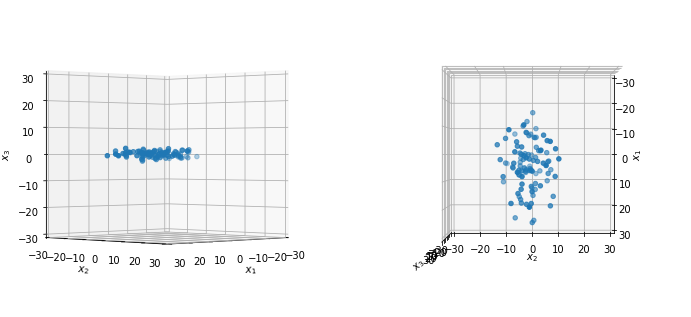

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

np.random.seed(1487432)

#generating a 100x3 dataset with 3 normally distributed variables
n = 100
d = 3
x_1 = np.random.normal(5, 10, size = n)
x_2 = np.random.normal(-2, 5, size = n)
x_3 = np.random.normal(0, 1, size = n)
X = np.column_stack((x_1, x_2, x_3))

#let's take a look at the data
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(222, projection="3d")
ax.scatter(x_1, x_2, x_3)
ax.set_xlim((-30, 30))
ax.set_ylim((-30, 30))
ax.set_zlim((-30, 30))
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
ax.view_init(90, 0)
ax2 = fig.add_subplot(221, projection = "3d")
ax2.scatter(x_1, x_2, x_3)
ax2.set_xlim((-30, 30))
ax2.set_ylim((-30, 30))
ax2.set_zlim((-30, 30))
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.set_zlabel("$x_3$")
ax2.view_init(0, 45)
plt.show()

Take note of the variance of each variable, $Var(x_1) > Var(x_2) > Var(x_3)$

In [19]:
import numpy as np
import matplotlib.pyplot as plt

class PCA:
    def __init__(self, data):
        self.data = data
        self.centeredData = None
        self.PCs = None
        self.PCscores = None
        self.varExp = None
        self.cumVarExp = None
        
    def center(self, data):
        rowMeans = data.sum(axis=0)/data.shape[0]
        return data - rowMeans
    
    def fit(self):
        self.centeredData = self.center(self.data)
        _, D, V = np.linalg.svd(self.centeredData)
        self.PCs = V
        self.PCscores = D**2
        self.varExp = self.PCscores/sum(self.PCscores)
        self.cumVarExp = np.cumsum(self.varExp)

    def reduce_ndim(self, ndim):
        assert ndim >= 0 and ndim <= self.centeredData.shape[1]
        return np.dot(self.centeredData, self.PCs[:,0:ndim])
    
    def reduce_varExp(self, varExpLimit):
        assert varExpLimit >= 0 and varExpLimit <= 1
        for index, cumVar in enumerate(self.cumVarExp):
            #if current cumulative variance explained is greater than the cutoff
            #guaranteed to be the smallest value such that this is true
            #use the index of this value to reduce dimensionality
            if cumVar > varExpLimit:
                cutoff = index
                break
            else:
                #takes care of when varExpLimit = 1
                cutoff = len(self.cumVarExp) + 1
        return np.dot(self.centeredData, self.PCs[:,0:cutoff])

## Testing

In [3]:
pca = PCA(X)
pca.fit()
pca.cumVarExp

array([ 0.76147214,  0.98978552,  1.        ])

So we can see that the first principal component explains 76% of the variation, the first and second explain 98.9% and clearly all three principal components explain 100%. Let's do two different reductions, one by dimension and one by amount of varation.  

In [4]:
reduced_by_dim = pca.reduce_ndim(2)
reduced_by_var = pca.reduce_varExp(0.99)

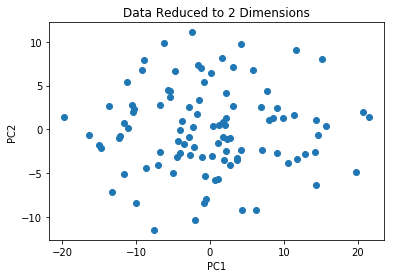

In [18]:
plt.scatter(reduced_by_dim[:,0], reduced_by_dim[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Data Reduced to 2 Dimensions")
plt.show()

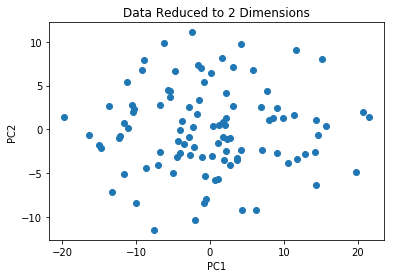

In [24]:
plt.scatter(reduced_by_var[:,0], reduced_by_var[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Data Reduced to 2 Dimensions")
plt.show()

Thankfully these look exactly the same, as they should. Also, note that the shape is similar to the top-down view of our 3D data, like it was projected onto the $x_1-x_2$ plane. This is essentially exactly what has happened. When we generated the data, $x_3$ had the smallest variance, therefore that dimension is the one that is "removed". Let's compare our output to sklearn's PCA implementation.

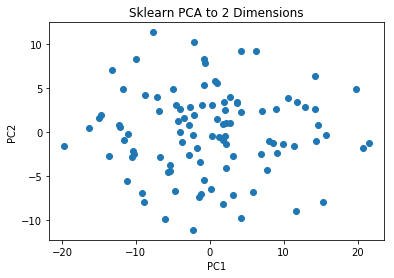

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
sklearn_reduced = pca.fit_transform(X)
plt.scatter(sklearn_reduced[:,0], sklearn_reduced[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Sklearn PCA to 2 Dimensions")
plt.show()

At first glance, this looks similar to our version, but it's not exact. However, it is the same data points simply reflected over the PC2 axis. This is due to a minor difference in the way the principal components were calculated. The sci-kit learn algorithm calculated the negative of the one we calculated. In the end they are essentially equivalent.

## Shortcomings of PCA

PCA is by no means the best choice for dimensionality reduction for all settings. 

 - PCA is a **linear** dimensionality reduction technique. If your data cannot be reduced in a linear fashion, i.e. onto hyperplanes, then PCA will not work well. For example if your data looks something like a spiral, PCA is not an optimal choice. In this case other techniques like multi-dimensional scaling and other non-linear reduction techniques will work better.
 
 - PCA is sensitive to scaling. Say you have two measurements of distance in your data, where one ranges from 0-1 meter and the other from 0-1000 millimeters. The latter variable will be seen as having more variance and thus be given more importance in the dimensionality reduction, despite them truly having roughly equal variation. This is the reason why it's a good idea to normalize your data before performing PCA.
 
 - PCA reduces interpretability. The original variables in our dataset likely have some real-world meaning attached to them. When we do PCA our new variables, the principal components, are linear combinations of our original variables. It makes a lot more sense to be able to say "everything else held constant, 1 year of education results in \$1000 increase in salary on average", than to say "everything else held constant, 0.78 years of education, -2.32 years of age, and 0.23 being male results in a $1000 increase in salary on average'.